Diabetes Test Using Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#for encoding
from sklearn.preprocessing import LabelEncoder
#for train test splitting
from sklearn.model_selection import train_test_split
#for decision tree object
from sklearn.tree import DecisionTreeClassifier
#for checking testing results
from sklearn.metrics import classification_report, confusion_matrix
#for visualizing tree 
from sklearn.tree import plot_tree

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Diabetes/

/content/drive/MyDrive/Diabetes


In [4]:
# Read data
diabetesdf = pd.read_csv('diabetes.csv')
print('Diabetes data shape: ', diabetesdf.shape)
diabetesdf.head()

Diabetes data shape:  (15000, 10)


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


Since Patient Id has not any important information we can drop that column

In [5]:
diabetesdf=diabetesdf.drop("PatientID",axis=1)

In [ ]:
#plot pair plot to visualise the attributes all at once
sns.pairplot(data=diabetesdf, hue = 'Diabetic')

Output hidden; open in https://colab.research.google.com to view.

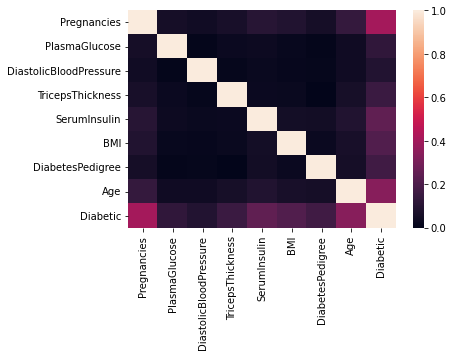

In [ ]:
# correlation matrix
sns.heatmap(diabetesdf.corr())

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for no diabetes, or a 1 indicating person is diabetic. We can first examine the number of person falling into each category.

In [6]:
diabetesdf['Diabetic'].value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

In [7]:
diabetesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pregnancies             15000 non-null  int64  
 1   PlasmaGlucose           15000 non-null  int64  
 2   DiastolicBloodPressure  15000 non-null  int64  
 3   TricepsThickness        15000 non-null  int64  
 4   SerumInsulin            15000 non-null  int64  
 5   BMI                     15000 non-null  float64
 6   DiabetesPedigree        15000 non-null  float64
 7   Age                     15000 non-null  int64  
 8   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.0 MB


Since all value are in numerical form there is no need of encoding

In [8]:
target = ['Diabetic']
X = diabetesdf.drop(target, axis=1)
Y = diabetesdf[target]

Seperating Test and Train Data

In [9]:
def TestTrain(df):
  trainData = df.sample(frac=0.9, random_state=25)
  testData = df.drop(trainData.index)

  # Export csv of train and test data
  trainData.to_csv( "trainData.csv", index=False, encoding='utf-8-sig')
  testData.to_csv( "testData.csv", index=False, encoding='utf-8-sig')

  return trainData, testData

In [10]:
trainX, testX = TestTrain(X)
trainY, testY = TestTrain(Y)
train_df,test_df = TestTrain(diabetesdf)

In [11]:
train_df

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
4505,6,144,90,52,429,27.108072,0.177102,45,1
8314,1,98,63,51,62,33.159252,0.608797,57,1
7131,0,97,82,33,32,20.993486,0.184766,35,0
7874,0,68,78,11,249,21.457434,0.114636,24,0
539,3,155,79,11,59,50.094045,0.180281,45,1
...,...,...,...,...,...,...,...,...,...
11885,0,99,52,34,36,36.485022,2.134993,22,0
3849,1,153,50,38,49,20.626999,0.083111,22,0
6880,0,128,84,43,163,21.944892,1.026098,25,0
2643,1,48,83,43,124,39.468595,0.594773,22,0


In [12]:
# Data wrangling 
import pandas as pd 

# Array math
import numpy as np 

# Quick value count calculator
from collections import Counter


class Node: 
    """
    Class for creating the nodes for a decision tree 
    """
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X

        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Calculating the counts of Y in the node 
        self.counts = Counter(Y)

        # Getting the GINI impurity based on the Y distribution
        self.gini_impurity = self.get_GINI()

        # Sorting the counts and saving the final prediction of the node 
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        # Getting the last item
        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]

        # Saving to object attribute. This node will predict the class with the most frequent class
        self.yhat = yhat 

        # Saving the number of observations in the node 
        self.n = len(Y)

        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 

        # Default values for splits
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        """
        Given the observations of a binary class calculate the GINI impurity
        """
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        # Getting the total observations
        n = y1_count + y2_count
        
        # If n is 0 then we return the lowest possible gini impurity
        if n == 0:
            return 0.0

        # Getting the probability to see each of the classes
        p1 = y1_count / n
        p2 = y2_count / n
        
        # Calculating GINI 
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        # Returning the gini impurity
        return gini

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window

    def get_GINI(self):
        """
        Function to calculate the GINI impurity of a node 
        """
        # Getting the 0 and 1 counts
        y1_count, y2_count = self.counts.get(0, 0), self.counts.get(1, 0)

        # Getting the GINI impurity
        return self.GINI_impurity(y1_count, y2_count)

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        GINI_base = self.get_GINI()

        # Finding which split yields the best GINI gain 
        max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Spliting the dataset 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                # Getting the Y distribution from the dicts
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)

                # Getting the left and right gini impurities
                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)

                # Getting the obs count from the left and the right data splits
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right

                # Calculating the weights for each of the nodes
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)

                # Calculating the weighted GINI impurity
                wGINI = w_left * gini_left + w_right * gini_right

                # Calculating the GINI gain 
                GINIgain = GINI_base - wGINI

                # Checking if this is the best split so far 
                if GINIgain > max_gain:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    max_gain = GINIgain

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                # Creating the left and right nodes
                left = Node(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = Node(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | GINI impurity of the node: {round(self.gini_impurity, 2)}")
        print(f"{' ' * const}   | Class distribution in the node: {dict(self.counts)}")
        print(f"{' ' * const}   | Predicted class: {self.yhat}")   

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

    def predict(self, X:pd.DataFrame):
        """
        Batch prediction method
        """
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        """
        Method to predict the class given a set of features
        """
        cur_node = self
        while cur_node.depth < cur_node.max_depth:
            # Traversing the nodes all the way to the bottom
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value

            if cur_node.n < cur_node.min_samples_split:
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right
            
        return cur_node.yhat

In [13]:
features = list(X.columns)
features

['Pregnancies',
 'PlasmaGlucose',
 'DiastolicBloodPressure',
 'TricepsThickness',
 'SerumInsulin',
 'BMI',
 'DiabetesPedigree',
 'Age']

In [18]:
hp = {
    'max_depth':10,
    'min_samples_split':2
}

In [19]:
root = Node(trainY, trainX, **hp)

In [17]:
root.grow_tree()

In [20]:
root.print_tree()

Root
   | GINI impurity of the node: 0.0
   | Class distribution in the node: {'Diabetic': 1}
   | Predicted class: Diabetic


In [ ]:
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=root.grow_tree, feature_names = X.columns, 
                     class_names =["0","1"] , filled = True , precision = 4, rounded = True)

TypeError: ignored

<Figure size 1440x1440 with 0 Axes>

In [ ]:
#plot pair plot to visualise the attributes all at once
sns.pairplot(data=diabetesdf, hue = 'Diabetic')

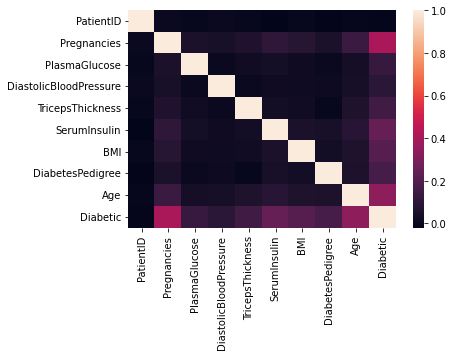

In [ ]:
# correlation matrix
sns.heatmap(diabetesdf.corr())